In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Conv2d work well or not 

In [3]:
#export
from exp.nb_02 import *

def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

In [4]:
x_train, y_train, x_valid,y_valid = get_data()
train_mean, train_std = x_train.mean(), x_train.std()
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [5]:
x_train = x_train.view(-1, 1, 28, 28) # one channel
x_valid = x_valid.view(-1, 1, 28, 28)
x_train.shape, x_valid.shape

(torch.Size([50000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [6]:
x_train.shape

torch.Size([50000, 1, 28, 28])

In [7]:
n,*_ = x_train.shape

In [8]:
c = y_train.max()+1
nh = 32
n, c

(50000, tensor(10))

In [9]:
l1 = nn.Conv2d(1, nh, 5) # 1: one channel, nh: 32 hidden layer, 5: 5*5 kernel

In [10]:
x = x_valid[:100]

In [11]:
x.shape

torch.Size([100, 1, 28, 28])

In [12]:
def stats(x): return x.mean(), x.std()

In [13]:
stats(l1.weight), stats(l1.bias )

((tensor(-0.0105, grad_fn=<MeanBackward0>),
  tensor(0.1145, grad_fn=<StdBackward0>)),
 (tensor(-0.0092, grad_fn=<MeanBackward0>),
  tensor(0.1227, grad_fn=<StdBackward0>)))

In [14]:
t = l1(x)

In [15]:
stats(t)

(tensor(-0.0352, grad_fn=<MeanBackward0>),
 tensor(0.6291, grad_fn=<StdBackward0>))

In [16]:
init.kaiming_normal_(l1.weight, a = 1.) # no ReLU but 1: 
stats(l1(x)) # we get the mean 0, variance 1 --> kaiming init

(tensor(-0.0147, grad_fn=<MeanBackward0>),
 tensor(1.0952, grad_fn=<StdBackward0>))

In [17]:
# with ReLU
import torch.nn.functional as F

In [18]:
def f1(x, a=0): return F.leaky_relu(l1(x), a)

In [19]:
init.kaiming_normal_(l1.weight, a = 0)
stats(f1(x))

(tensor(0.5739, grad_fn=<MeanBackward0>),
 tensor(1.1062, grad_fn=<StdBackward0>))

In [20]:
# defult worse?
l1 = nn.Conv2d(1, nh, 5)

In [21]:
stats(f1(x))

(tensor(0.2360, grad_fn=<MeanBackward0>),
 tensor(0.4247, grad_fn=<StdBackward0>))

Decide to write out own kaiming init.
If we are workign with a regular fully connected matrix multiplication,  we would say how many output filters are there.  
**Weight matrix**: for a conv layer, 

In [22]:
l1.weight.shape

torch.Size([32, 1, 5, 5])

In [23]:
rec_fs = l1.weight[0, 0].numel() # receptive filter size, how many elements in that kernel
rec_fs

25

In [24]:
nf, ni, *_ = l1.weight.shape # number of filters out, in and rest.
nf, ni

(32, 1)

In [25]:
# for kaiming he init, we can calculate
fan_in = ni*rec_fs
fan_out = nf*rec_fs

fan_in, fan_out

(25, 800)

In [26]:
# the Kaiming init formula, the gain for the init
def gain(a): return math.sqrt(2.0/1+a**2)
# for the pytorch init, it is `gain(math.sqrt(5.))` 

the pytorch used init is not kaiming init but kaiming uniform `kaiming_uniform_`.  
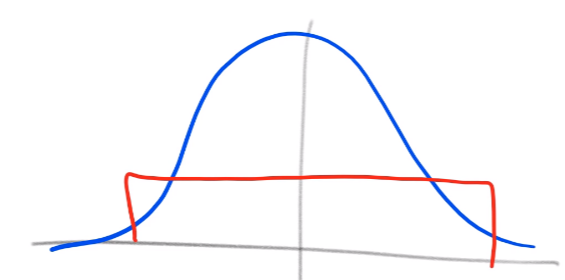

In [27]:
torch.zeros(10000).uniform_(-1, 1).std()

tensor(0.5771)

In [28]:
1./math.sqrt(3.)

0.5773502691896258

In [29]:
# new version of kaiming
def kaiming2(x, a, use_fan_out = False):
    nf, ni, *_ = x.shape
    rec_fs = x[0, 0].shape.numel()
    fan = nf*rec_fs if use_fan_out else ni*rec_fs
    std =gain(a)/math.sqrt(fan)
    bound = math.sqrt(3.)*std
    x.data.uniform_(-bound, bound)

In [30]:
kaiming2(l1.weight, a = 0);
stats(f1(x))

(tensor(0.4907, grad_fn=<MeanBackward0>),
 tensor(0.8207, grad_fn=<StdBackward0>))

In [31]:
kaiming2(l1.weight, a = math.sqrt(5.));
stats(f1(x))

(tensor(0.9192, grad_fn=<MeanBackward0>),
 tensor(1.6304, grad_fn=<StdBackward0>))

In [32]:
class Flatten(nn.Module):
    def forward(self, x): return x.view(-1)

In [33]:
m = nn.Sequential(
    nn.Conv2d(1, 8, 5, stride = 2, padding = 2), nn.ReLU(),
    nn.Conv2d(8, 16, 3, stride = 2, padding = 1), nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride = 2, padding = 1), nn.ReLU(),
    nn.Conv2d(32, 1, 3, stride = 2, padding = 1),
    nn.AdaptiveAvgPool2d(1),
    Flatten()
)

In [34]:
y = y_valid[:100].float

In [35]:
t = m(x)
stats(t)

(tensor(0.0123, grad_fn=<MeanBackward0>),
 tensor(0.0055, grad_fn=<StdBackward0>))

In [36]:
def mse(output, targ): return (output.squeeze(-1)-targ).pow(2).mean() 

###############################################

## Data and Model

In [37]:
from exp.nb_02 import *
import torch.nn.functional as F

In [38]:
mpl.rcParams['image.cmap'] = 'gray'

In [39]:
x_train, y_train, x_valid, y_valid = get_data()

In [40]:
n, m= x_train.shape
c = y_train.max()+1

In [41]:
n, m

(50000, 784)

In [42]:
nh = 50

In [43]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [44]:
model = Model(m, nh, 10)
pred = model(x_train)

In [45]:
pred.shape

torch.Size([50000, 10])

# Softmax Cross entropy loss

In [46]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim = True))).log()
# def log_softmax(x): return x-x.exp().sum(-1, keepim=True).log()

Cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:
$$-\sum(x\log p(x))$$
Because our $x$s are 1-hot encoded, this can be rewitten as $-\log(p_i)$, **negative log liklyhood**.

In [47]:
y_train[:3];
y_train.shape[0]

50000

In [48]:
sm_pred = log_softmax(pred) # softmax prediction

In [49]:
# negative log liklyhood
# range[targ.shape[0]]: row indexes
def nll(input, targ): return -input[range(targ.shape[0]), targ].mean()

Index like `sm_pred[[0, 1, 2][5, 0, 4]]`. Pytorch supports all adavanced index things of numpy, **integer array indexing**

In [50]:
loss = nll(sm_pred, y_train)

In [51]:
# logsumexp trick
def logsumexp(x):
    m = x.max(-1)[0]
    return m+(x-m[:None]).exp().sum(-1).log()

In [52]:
def log_softmax(x): return x - x.logsumexp(-1, keepim=True)

In [53]:
import torch.nn.functional as F
test_near(F.cross_entropy(pred, y_train), loss) # tested and we successfully build cross-entropy loss

## Basic Training loop

In [54]:
loss_func = F.cross_entropy

In [55]:
#export
def accuracy (out, yb): return (torch.argmax(out, dim = 1)==yb).float().mean()
# in pytorch, the mean() you take need to be float(), can not be int().

In [56]:
bs = 64 # batch size
xb = x_train[0:bs]  # x_batch, a mini batch from x
preds = model(xb)

In [57]:
preds.shape

torch.Size([64, 10])

In [58]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3056, grad_fn=<NllLossBackward>)

In [59]:
accuracy(preds, yb)

tensor(0.0625)

In [60]:
lr = 0.5 # learning rate

epochs = 5 # how many epochs to train for

for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'): # check whether the layers has attribute called weight
                    l.weight -= l.weight.grad*lr
                    l.bias -= l.bias.grad*lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()                   

In [61]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0023, grad_fn=<NllLossBackward>), tensor(1.))

## Using parameters and optim

In [62]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [63]:
model = Model(m, nh, 10)

In [64]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [65]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [66]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs+1):
            start_i = i*bs
            end_i = start_i + bs
            
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            
            loss = loss_func(model(xb), yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad*lr
                model.zero_grad()

In [67]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0048, grad_fn=<NllLossBackward>), tensor(1.))

In [68]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters():
                yield p

In [69]:
mdl = DummyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [70]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

We can use the original `layers` approah, but we have to register the module. where we have made a layers list

In [71]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [72]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
            
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [73]:
model = Model(layers)

In [74]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

## nn.Sequential

In [75]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [76]:
fit()

In [77]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0037, grad_fn=<NllLossBackward>), tensor(1.))

## Optim 

In [78]:
class Optimizer():
    def __init__(self, parms, lr = 0.5): self.parms, self.lr = list(parms), lr
        
    def step(self):
        with torch.no_grad():
            for p in self.parms:
                p -= p.grad*lr
                
    def zero_grad(self):
        for p in self.parms: p.grad.data.zero_()

In [79]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [80]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(2.2891, grad_fn=<NllLossBackward>), tensor(0.1875))

`optim.SGD` it also handles stuff like momentum

In [81]:
#export
from torch import optim # does weight_decay, momentum...

In [82]:
def get_model():
    mdoel = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr = lr)

In [83]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.2891, grad_fn=<NllLossBackward>)

In [84]:
for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [85]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0050, grad_fn=<NllLossBackward>), tensor(1.))

In [86]:
assert acc > 0.98

## Dataset and DataLoader 
It is clunky to iterate through minibatches of $x$ and $y$ values separately:  
    `xb = x_train[start_i:end_i]`  
    `yb = y_train[start_i:end_i]`  
Instead, do these two steps together by `Dataset` class:  
    `xb, yb = train_ds[i*bs:i*bs+bs]`

In [87]:
#export
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [88]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train), len(valid_ds) == len(x_valid)

In [89]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 784)
assert yb.shape == (5, )

In [90]:
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [91]:
for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        xb, yb = train_ds[i*bs:i*bs+bs]
        
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [92]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.9
loss, acc

(tensor(0.0011, grad_fn=<NllLossBackward>), tensor(1.))

To make our loop cleaner, use the data loader:
```python
for xb, yb in train_dl:
    ...
```

In [93]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [94]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

tensor(3)

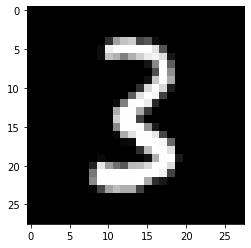

In [95]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [96]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [97]:
fit()

## Random sampling
We want our training set to be in a random order, and that order should differ each iteration. But the validation set should not be randomized.

In [98]:
class Sampler():
    def __init__(self, ds, bs, shuffle = False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [99]:
small_ds = Dataset(*train_ds[:10])

In [100]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [101]:
s = Sampler(small_ds, 3, True) # shuffle = True
[o for o in s]

[tensor([8, 6, 5]), tensor([0, 4, 3]), tensor([1, 9, 7]), tensor([2])]

In [102]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [103]:
class DataLoader():
    def __init__(self, ds, sampler, collate_fn = collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [104]:
train_samp = Sampler(train_ds, bs, shuffle = True)
valid_samp = Sampler(valid_ds, bs, shuffle = True)

In [105]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn = collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn = collate)

tensor(5)

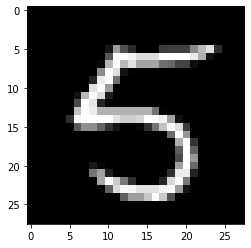

In [106]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [107]:
model, opt = get_model()
fit()

loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.9

loss, acc

(tensor(0.1059, grad_fn=<NllLossBackward>), tensor(0.9688))

## Pytorch DataLoader

In [108]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler # slight different for the API, but did the same thing

In [109]:
train_dl = DataLoader(train_ds, bs, sampler = RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler = SequentialSampler(valid_ds), collate_fn=collate)

In [110]:
model, opt = get_model()
fit()
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)

Pytorch DataLoader work fine for most things but if you pass `num_workers`, it will use multiple threads to call your Dataset

## Validation

In [111]:
def fit(epochs, model, los_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
                
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [114]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [115]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()

loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1459) tensor(0.9732)
1 tensor(0.1373) tensor(0.9749)
2 tensor(0.1456) tensor(0.9741)
3 tensor(0.1391) tensor(0.9747)
4 tensor(0.1382) tensor(0.9746)


**Q: Why do we need to zero the gradients?**  
**A:** i) If we do not do that, the new gradient will be add to the existing gradient, we often have a lot of source of gradients, they all have to be added up.  
__ ii) For the optimizer, the stability of the gradients that you get from a batch size of the two is so poor that you need to use a larger batch size.